$$\newcommand{\Rv}{\mathbf{R}}
\newcommand{\rv}{\mathbf{r}}
\newcommand{\Qv}{\mathbf{Q}}
\newcommand{\Qnv}{\mathbf{Qn}}
\newcommand{\Av}{\mathbf{A}}
\newcommand{\Aiv}{\mathbf{Ai}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\betav}{\mathbf{\beta}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Uv}{\mathbf{U}}
\newcommand{\uv}{\mathbf{u}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\TDv}{\mathbf{TD}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\Gv}{\mathbf{G}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
\newcommand{\grad}{\mathbf{\nabla}}
\newcommand{\ebx}[1]{e^{\betav_{#1}^T \xv_n}}
\newcommand{\eby}[1]{e^{y_{n,#1}}}
\newcommand{\Tiv}{\mathbf{Ti}}
\newcommand{\Fv}{\mathbf{F}}
\newcommand{\ones}[1]{\mathbf{1}_{#1}}
$$

# Reinforcement Learning to Control a Marble

Remember the one-dimensional maze example from last time.  

We can make our one-dimensional maze problem into a realistic control
problem by saying we have a marble on a one-dimensional track that has
a mass and real-valued position and velocity values.  So the state is
actually two-dimensional, position, $x$, and velocity,
$\dot{x}$. Actions are forces on the marble and let's just allow three
forces, $-1$, $0$, and $1$.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import neuralnetworks as nn   # from notes 09

As before, we define the ```reinforcement```, ```initialState```, and ```nextState``` functions to specify our dynamic marble problem.

In [4]:
from copy import copy

actions = (-1, 0, 1)   # Possible actions

def reinforcement(s, s1):
    goal = 5
    return 0 if abs(s1[0]-goal) < 1 else -1
    # return -abs(s1[0] - goal)

def initialState():
    return np.array([10 * np.random.random_sample(), 0.0])

def nextState(s, a):
    s = copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = [0,0]
    elif s[0] > 10:
        s = [10,0]
    return s

We also need our ```epsilonGreedy``` function.

In [5]:
def epsilonGreedy(nnetQ, state, actions, epsilon):
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
    else:
        # Greedy Move
        Qs = [nnetQ.use(np.hstack((state, a)).reshape((1, -1))) for a in actions]
        ai = np.argmax(Qs)
        action = actions[ai]
    Q = nnetQ.use(np.hstack((state, action)).reshape((1, -1)))
    return action, Q

The ```makeSamples``` function is still general.  We modify the one from the previous notes just a bit to allow our state variable to contain multiple values.

In [6]:
def makeSamples(nnet, initialStateF, nextStateF, reinforcementF,
                validActions, numSamples, epsilon):

    X = np.zeros((numSamples, nnet.n_inputs))
    R = np.zeros((numSamples, 1))
    Qn = np.zeros((numSamples, 1))

    s = initialStateF()
    s = nextStateF(s, 0)        # Update state, sn from s and a
    a, _ = epsilonGreedy(nnet, s, validActions, epsilon)

    # Collect data from numSamples steps
    for step in range(numSamples):
        sn = nextStateF(s, a)        # Update state, sn from s and a
        rn = reinforcementF(s, sn)   # Calculate resulting reinforcement
        an, qn = epsilonGreedy(nnet, sn, validActions, epsilon) # Forward pass for time t+1
        X[step, :] = np.hstack((s, a))
        R[step, 0] = rn
        Qn[step, 0] = qn
        # Advance one time step
        s, a = sn, an

    return (X, R, Qn)

Like before, let's make a *plotStatus* function to show us how we are doing.

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plotStatus(net, trial, epsilonTrace, rtrace):
    plt.subplot(4, 3, 1)
    plt.plot(epsilonTrace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)
    plt.subplot(4, 3, 2)
    plt.plot(X[:, 0])
    plt.plot([0, X.shape[0]], [5, 5], '--', alpha=0.5, lw=5)
    plt.ylabel('$x$')
    plt.ylim(-1, 11)
    qs = net.use(np.array([[s, 0, a] for a in actions for s in range(11)]))
    plt.subplot(4, 3, 3)
    acts = ['L', '0', 'R']
    actsiByState = np.argmax(qs.reshape((len(actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2, 'Policy for Zero Velocity')
    plt.axis('off')
    plt.subplot(4, 3, 4)
    plt.plot(rtrace[:trial + 1], alpha=0.5)
    binSize = 20
    if trial + 1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial / binSize) * binSize].reshape((int(trial / binSize), binSize)),
                           axis=1)
        plt.plot(np.arange(1, 1 + int(trial / binSize)) * binSize, smoothed)
    plt.ylabel('Mean reinforcement')
    plt.subplot(4, 3, 5)
    plt.plot(X[:, 0], X[:, 1])
    plt.plot(X[0, 0], X[0, 1], 'o')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.fill_between([4, 6], [-5, -5], [5, 5], color='red', alpha=0.3)
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.subplot(4, 3, 6)
    net.draw(['$x$', '$\dot{x}$', '$a$'], ['Q'])
    
    plt.subplot(4, 3, 7)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities =  np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = net.use(np.array([[xsflat[i], ysflat[i], a] for a in actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')
    plt.subplot(4, 3, 8)
    acts = np.array(actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')
    
    s = plt.subplot(4, 3, 10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, qsmax, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')
    
    s = plt.subplot(4, 3, 11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(), rect=rect)
    ax.plot_surface(xs, ys, acts, cstride=1, rstride=1, cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')
    
    plt.tight_layout()

And, let's write a function to plop the marble down at a number of positions and try to control it, plotting the results.

In [8]:
def testIt(Qnet, nTrials, nStepsPerTrial):
    xs = np.linspace(0, 10, nTrials)
    plt.subplot(4, 3, 12)
    for x in xs:
        s = [x, 0] # 0 velocity
        xtrace = np.zeros((nStepsPerTrial, 2))
        for step in range(nStepsPerTrial):
            a,_ = epsilonGreedy(Qnet, s, actions, 0.0) # epsilon = 0
            s = nextState(s, a)
            xtrace[step, :] = s
        plt.plot(xtrace[:, 0], xtrace[:, 1])
        plt.xlim(-1, 11)
        plt.ylim(-5, 5)
        plt.plot([5, 5], [-5, 5], '--', alpha=0.5, lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [9]:
def setupStandardization(net, Xmeans, Xstds, Tmeans, Tstds):
    net.Xmeans = Xmeans
    net.XstdsFixed = Xstds
    net.Xconstant = [False] * len(Xmeans)
    net.TstdsFixed = net.Tstds = Tstds
    net.Tmeans = Tmeans
    net.Tconstant = [False] * len(Tstds)

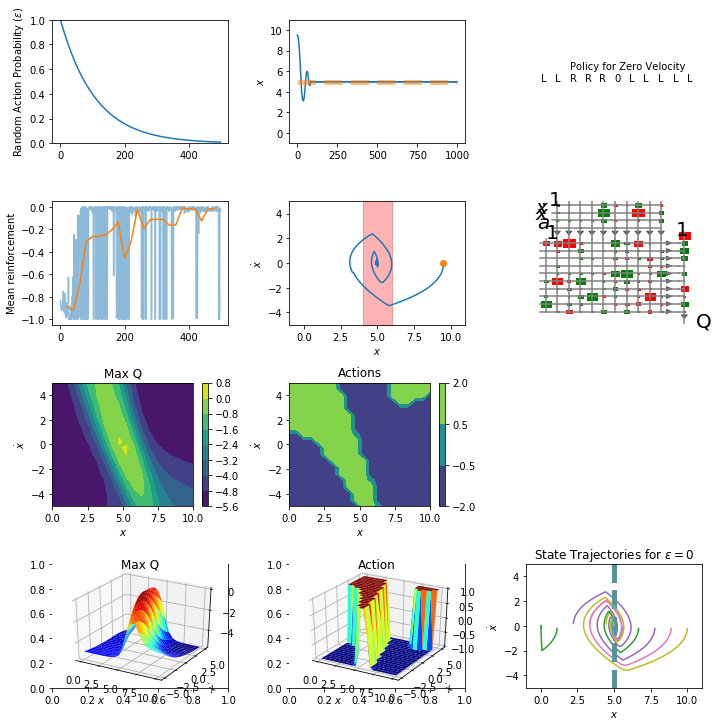

In [11]:
from IPython.display import display, clear_output
fig = plt.figure(figsize=(10 ,10))

gamma = 0.8           # discount factor
nTrials = 500         # number of repetitions of makeSamples-updateQ loop
nStepsPerTrial = 1000 # number of steps between new random initial states
nSCGIterations = 4    # maximum number of SCG iterations
finalEpsilon = 0.01   # value of epsilon at end of simulation. Decay rate is calculated
epsilonDecay =  np.exp(np.log(finalEpsilon) / (nTrials)) # to produce this final value
print('epsilonDecay is',epsilonDecay)

nh = [10, 10]           # number of hidden units
nnetQ = nn.NeuralNetwork(3, nh, 1)
# Inputs are position (1 to 10) velocity (-3 to 3) and action (-1, 0, or 1)
setupStandardization(nnetQ, [5, 0, 0], [2, 2, 0.5], [0], [1])

epsilon = 1         # initial epsilon value
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    
    X, R, Qn = makeSamples(nnetQ, initialState, nextState, reinforcement, actions, nStepsPerTrial, epsilon)
    nnetQ.train(X, R + gamma * Qn, n_epochs=nSCGIterations)

    # X,R,Qn,Q,epsilon = getSamples(Qnet,actions,nStepsPerTrial,epsilon)
    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    epsilon *= epsilonDecay
    rtrace[trial] = np.mean(R)
    if True and (trial + 1 == nTrials or trial % (nTrials / 40) == 0):
        fig.clf()
        plotStatus(nnetQ, trial, epsilonTrace, rtrace)
        testIt(nnetQ, 10, 500)
        clear_output(wait=True)
        display(fig)
    
clear_output(wait=True)